This is going to randomly sample, but then also return consective data points. both based on a dim

In [7]:
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import numpy as np
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class WaveformDataset(Dataset):
    def __init__(self, wav_data, t_input):
        self.wav_data = wav_data
        self.time_steps = t_input
        self.length = len(wav_data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.wav_data[idx], self.time_steps[idx]

In [9]:
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


    
    

wav_data = np.linspace(1,100,100).tolist()  # Example waveform data
t_input = np.linspace(1,100,100).tolist()  # Example time step data

dataset = WaveformDataset(wav_data, t_input)
batch_size = 17
consecutive_size = 13

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)



In [10]:
def consecutive_dif(prediction, target, consecutive_size):
    """
    This will calculate the differences across consecutive points.  
    use RandomConsecutiveSampler for intended results
    """
    pred_reshape = prediction.view(-1,consecutive_size)
    target_reshape = target.view(-1,consecutive_size)
    pred_dif = pred_reshape[:,1:] - pred_reshape[:,:-1]
    target_dif = target_reshape[:,1:] - target_reshape[:,:-1]
    return torch.mean((pred_dif - target_dif)**2)


class ConsecutiveBorderCrossingAbs(nn.Module):
    def __init__(self, consecutive_size, temperature = 1.0):
        super(ConsecutiveBorderCrossingAbs, self).__init__()
        """just looks at where it crosses zero, also, do i even need tanh?"""
        self.consecutive_size = consecutive_size
        self.bce_loss = nn.BCELoss()
        self.temp = temperature

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        target_sign_tensor = torch.sign(target_reshape)
        target_sign_diff = (target_sign_tensor[:,1:] - target_sign_tensor[:,:-1])/2 #-1,0,and 1 only
        target_sign_diff = (target_sign_diff + 1)/2 #bce ready
        
        pred_abs = torch.abs(pred_reshape)
        pred_sign_reshape = pred_reshape/pred_abs
        pred_sign_dif = pred_sign_reshape[:,1:] - pred_sign_reshape[:,:-1] #-2,0,2
        tan_pred = torch.tanh(self.temp * pred_sign_dif)
        bce_ready_pred = (tan_pred + 1)/2
        loss = self.bce_loss(bce_ready_pred.float(),target_sign_diff.float())
        print(bce_ready_pred,target_sign_diff)
        return loss

class ConsecutiveBorderCrossing(nn.Module):
    def __init__(self, consecutive_size, temperature = 1.0):
        super(ConsecutiveBorderCrossing, self).__init__()
        """just looks at where it crosses zero, also, do i even need tanh?"""
        self.consecutive_size = consecutive_size
        self.bce_loss = nn.BCELoss()
        self.temp = temperature

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        
        target_sign_tensor = self.temp*torch.sign(target_reshape)
        target_sign_diff = (target_sign_tensor[:,1:] - target_sign_tensor[:,:-1])/2 #-1,0,and 1 only
        bce_ready_target = (target_sign_diff + 1)/2 #bce ready
        
        
        pred_sign_reshape = self.temp*torch.tanh(self.temp*pred_reshape) #-1 to 1
        pred_sign_dif = torch.tanh(pred_sign_reshape[:,1:] - pred_sign_reshape[:,:-1]) #-1 to 1
        bce_ready_pred = (pred_sign_dif + 1)/2 #0 to 1
        print(pred_sign_reshape,pred_sign_dif)
        loss = self.bce_loss(bce_ready_pred,bce_ready_target)
        
        return loss

class ConsecutiveDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)
    
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        return torch.mean((pred_dif - target_dif) ** 2)

   
# variations.  you can do the differences with all the other consecutive points.  
# you could do differences along the batch.  those are consecutive points but they shift one each time
# weight those with the dif in t.  that could be interesting.  
#might add in another dataloader? a completely random one? what if you use mse on the random one? 
#thats interesting.  or maybe just weird.  
#no its interesting.  you learn the slopes from differences, then the vertical shift from mse on different points.  
# try these on a single wave to learn frequency.  then add in phi?

class ConsecutiveDifferenceLossAndBatch(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveDifferenceLossAndBatch, self).__init__()
        """
        This does the consecutive loss as well as the batch loss.  
        This does look consecutively differences across batches, i wonder how that will effect it.  
        
        """
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_dif = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        pred_dif_batch = pred_reshape[1:, :] - pred_reshape[:-1, :]
        target_dif_batch = target_reshape[1:, :] - target_reshape[:-1, :]
        
        consec_loss = torch.mean((pred_dif - target_dif) ** 2)
        batch_loss = torch.mean((pred_dif_batch - target_dif_batch) ** 2)
        
        return consec_loss + batch_loss

    
class ConsecutiveSlopeWeightedMSELoss(nn.Module):
    def __init__(self, consecutive_size):
        super(ConsecutiveSlopeWeightedMSELoss, self).__init__()
        """this is just mse weighted by how different the slope before and after the point is"""
        self.consecutive_size = consecutive_size

    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        #pred_dif = pred_reshape[:, 1:] - pred_reshape[:, :-1]
        target_slope = target_reshape[:, 1:] - target_reshape[:, :-1]
        
        target_slope_dif = target_slope[:, 1:] - target_slope[:, :-1]
        
        
        errors = pred_reshape[:,1:-1] - target_reshape[:,1:-1]
        
        return torch.mean(target_slope_dif **2 * errors **2)

class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result

    
class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class WeightedMSELoss(nn.Module):
    def __init__(self,max_amp = 142.76):
        super(WeightedMSELoss, self).__init__()
        self.max_amp = max_amp
        
    def forward(self, predictions, targets):
        assert predictions.size() == targets.size(), "Size mismatch between predictions and targets"
        
        target_weights = (targets/self.max_amp) ** 2
        squared_error = (predictions - targets) ** 2
        
        weighted_error = target_weights * squared_error
        
        loss = torch.mean(weighted_error)
        return loss

In [51]:
from torch.autograd import Function
class DualSlopeSquareWaveFunction(Function):
    @staticmethod
    def forward(ctx, t, high_slope, low_slope):
        # Save tensors for backward pass
        ctx.save_for_backward(t, high_slope, low_slope)
        
        # Compute the base square wave
        square_wave = torch.sign(torch.sin(2 * torch.pi * t))
        
        # Identify high and low parts using the square wave values
        high_part = (square_wave >= 0).float()
        low_part = (square_wave < 0).float()
        
        # Calculate the slope correction for high and low parts separately
        time_in_period = t % 1
        high_slope_correction = high_slope * time_in_period * high_part
        low_slope_correction = low_slope * time_in_period * low_part

        # Apply the slope correction
        square_wave_with_slope = high_slope_correction + low_slope_correction
        
        return square_wave_with_slope

    @staticmethod
    def backward(ctx, grad_output):
        t, high_slope, low_slope = ctx.saved_tensors
        
        # Initialize gradients
        grad_t = torch.zeros_like(t)
        grad_high_slope = torch.zeros_like(high_slope)
        grad_low_slope = torch.zeros_like(low_slope)
        
        # Compute the base square wave and sine
        sine_wave = torch.sin(2 * torch.pi * t)
        square_wave = torch.sign(sine_wave)
        
        # Identify high and low parts using the square wave values
        high_part = (square_wave >= 0).float()
        low_part = (square_wave < 0).float()
        
        # Calculate the slope correction for high and low parts separately
        time_in_period = t % 1

        # Gradient w.r.t. t
        
        grad_t += high_slope * high_part * grad_output + low_slope * low_part * grad_output

        # Gradients w.r.t. high_slope and low_slope
        grad_high_slope = torch.sum(time_in_period * high_part * grad_output, dim=0)
        grad_low_slope = torch.sum(time_in_period * low_part * grad_output, dim=0)
        
        return grad_t, grad_high_slope, grad_low_slope

class DualSlopeSquareWaveLayer(nn.Module):
    def __init__(self, param_dim):
        super(DualSlopeSquareWaveLayer, self).__init__()
        # Initialize the parameters with torch.randn
        self.f = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.A = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.high_slope = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.low_slope = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.phi = nn.Parameter(torch.randn(param_dim, dtype=torch.float32))
        self.param_dim = param_dim

    def forward(self, t):
        # Expand t to match param_dim
        t = t.unsqueeze(-1)  # Now t is [batch_size, 1]
       
    
        # Calculate the transformed t based on frequency, amplitude, and phase shift
        transformed_t = self.f * t + self.phi
        # Apply the DualSlopeSquareWaveFunction with the transformed t and slopes
        dual_slope_wave = DualSlopeSquareWaveFunction.apply
        output = dual_slope_wave(transformed_t, self.high_slope, self.low_slope)
        
        # Scale the output by the amplitude A
        output = self.A * output
        
        # Sum over the parameter dimension
        output = torch.sum(output, dim=-1)
        
        return output
    
class DualSlopeSquareWaveNetwork(nn.Module):
    def __init__(self, layer_dims):
        super(DualSlopeSquareWaveNetwork, self).__init__()
        
        # Create a list to hold the layers
        self.layers = nn.ModuleList()
        
        # Iterate through the list of layer dimensions and create layers
        for param_dim in layer_dims:
            layer = DualSlopeSquareWaveLayer(param_dim=param_dim)
            self.layers.append(layer)
    
    def forward(self, t):
        # Pass the input t through each layer sequentially
        for layer in self.layers:
            t = layer(t)
        return t.unsqueeze(-1)

In [148]:
layer_dims = [100,100,100,1]
model = DualSlopeSquareWaveNetwork(layer_dims=layer_dims)

In [143]:
def add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1):
    """
    Adds Gaussian noise to the beginning and end of the data.
    
    Parameters:
        data (numpy.ndarray): The input data to which noise will be added.
        noise_std (float): The standard deviation of the Gaussian noise.
        noise_fraction (float): The fraction of the data at the beginning and end where noise will be added.
    
    Returns:
        numpy.ndarray: Data with added Gaussian noise.
    """
    # Determine the length of the data and the size of the noise sections
    data_len = len(data)
    noise_len = int(data_len * noise_fraction)

    # Generate Gaussian noise for the beginning and end of the data
    noise_start = np.random.normal(0, noise_std, noise_len)
    noise_end = np.random.normal(0, noise_std, noise_len)

    # Create a copy of the data to modify
    noisy_data = data.copy()

    # Add noise to the beginning and end
    noisy_data[:noise_len] = noise_start
    noisy_data[-noise_len:] = noise_end

    return noisy_data


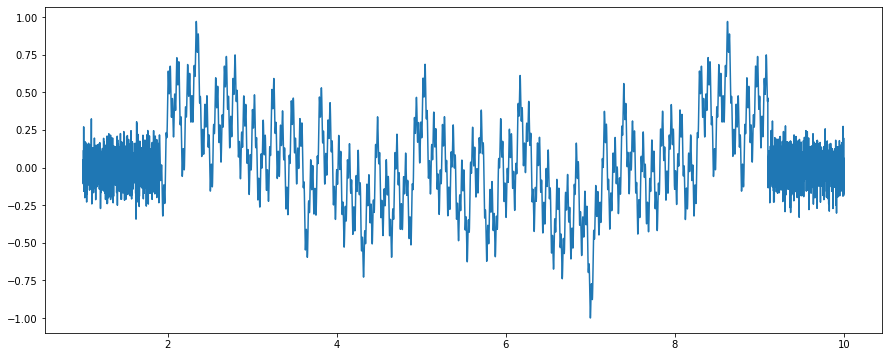

In [149]:

data_t = torch.from_numpy(np.linspace(1,10,10_000))

data =  (16*torch.sin(2*data_t+3)  
    + 2*torch.sin(6*data_t+1.93)  
    + 12*torch.sin(26*data_t+4.2) 
    + 16*torch.sin(21*data_t+2.43)  
    + 33*torch.sin(56*data_t+1.9)  
    + 11*torch.sin(17*data_t+24) 
    + 7.5*torch.sin(2*data_t+3)  
    + 9.4*torch.sin(6*data_t+1.93)  
    + 15.7*torch.sin(246*data_t+4.2) 
    + 17.5*torch.sin(11*data_t+2.43)  
    + 18*torch.sin(5*data_t+1.9)  
    + 25.8*torch.sin(1*data_t+24) )
data = data.detach().numpy().astype(np.float64)
max_amp = max(abs(data))
data = data/max_amp
data = add_gaussian_noise(data, noise_std=0.1, noise_fraction=0.1)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')

Sample Rate: 24000
Data Shape: (14400,)
21397


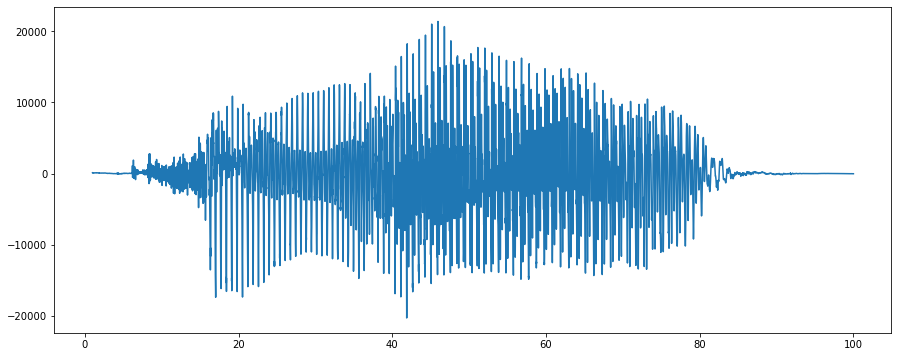

In [63]:
import numpy as np
from scipy.io import wavfile

# Load the WAV file
file_path = 'hello.wav'
sample_rate, data = wavfile.read(file_path)

# Print out the sample rate and the shape of the numpy array
print("Sample Rate:", sample_rate)
print("Data Shape:", data.shape)
data_t = torch.from_numpy(np.linspace(1,100,data.shape[0]))

##data = data.detach().numpy().astype(np.float64)
plt.figure(figsize=(15, 6))

plt.plot(data_t, data, label='Layer Output')
max_amp = max(abs(data))
print(max_amp)


In [150]:
dataset = WaveformDataset(data, data_t)
batch_size = 200
consecutive_size = 20

sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)
data_loader = DataLoader(dataset, batch_sampler=sampler)

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming you have defined your model, loss function, and optimizer
# Example:
# model = YourModel()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=4)
#ConsecutiveDifferenceLoss(consecutive_size)  #ConsecutiveDifferenceLossAndBatch(consecutive_size) #  consecutive_dif(prediction, target, consecutive_size)
mse_loss = WeightedMSELoss(1) #nn.MSELoss() #ConsecutiveSlopeWeightedMSELoss(consecutive_size) #
optimizer = optim.Adam(model.parameters(), lr=0.005)
ms = nn.MSELoss()
#bc_loss = ConsecutiveBorderCrossingAbs(consecutive_size,temperature=5.0)
# Training loop
num_epochs = 50 # Set the number of epochs
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, ( targets,inputs) in enumerate(data_loader):
        # Move data to the appropriate device (GPU/CPU)
        #inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        mse = mse_loss(outputs, targets.unsqueeze(-1))
        cdif = cdif_loss(outputs, targets)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(outputs, targets)
        m = ms(outputs , targets.unsqueeze(-1))

        loss =  0.1*m + 0.8*cdif + 0.5*cdif_b #0.5* cdif + 0.5*cdif_b + 0.5*mse
        #loss =  cdif + m/200
        loss.backward()
        
        optimizer.step()

        # Print statistics
        running_loss += loss.item() #this can nan because of how i'm aggregating it.  average yo
    
    if epoch % 5 == 4:  # Print every 10 mini-batches
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / 10:.4f}')
    running_loss = 0.0
        
print('Training finished.')


Epoch [5/50], Loss: 2.2308
Epoch [10/50], Loss: 2.2653
Epoch [15/50], Loss: 2.2614
Epoch [20/50], Loss: 2.2645
Epoch [25/50], Loss: 2.2591
Epoch [30/50], Loss: 2.2207
Epoch [35/50], Loss: 2.1801
Epoch [40/50], Loss: 2.1959
Epoch [45/50], Loss: 2.2348
Epoch [50/50], Loss: 2.2711
Training finished.


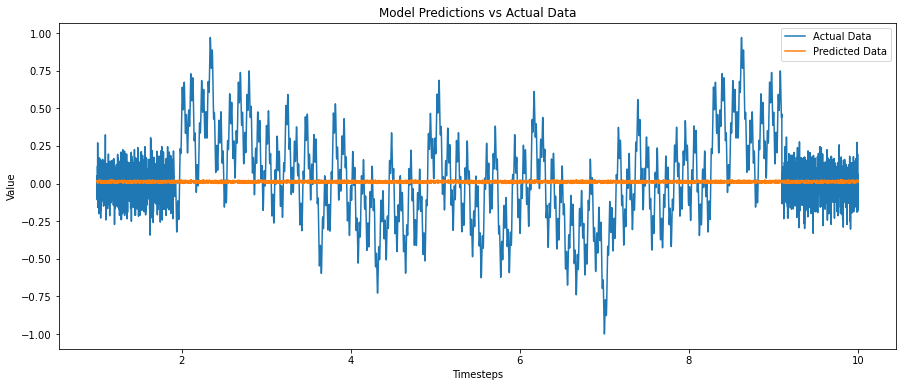

In [154]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Assuming data contains the targets and data_t contains the input timesteps
data_loader_eval = DataLoader(WaveformDataset(data, data_t), batch_size=50, shuffle=False)

with torch.no_grad():
    predictions = []
    actuals = []
    timesteps = []
    for  batch_data,batch_t in data_loader_eval:
        #batch_t, batch_data = batch_t.to(device), batch_data.to(device)
        outputs = model(batch_t)
        predictions.append(outputs.cpu().numpy())
        actuals.append(batch_data.cpu().numpy())
        timesteps.append(batch_t.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)
timesteps = np.concatenate(timesteps, axis=0)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot( timesteps.flatten(),actuals.flatten(), label='Actual Data')
plt.plot( timesteps.flatten(),predictions.flatten(), label='Predicted Data')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.title('Model Predictions vs Actual Data')
plt.show()


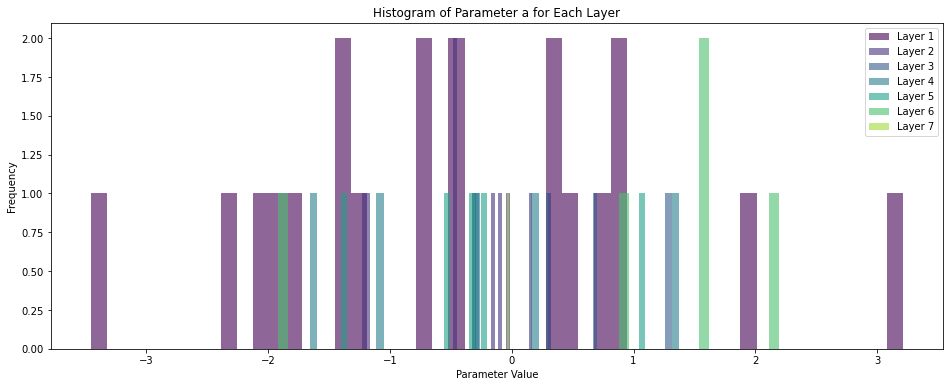

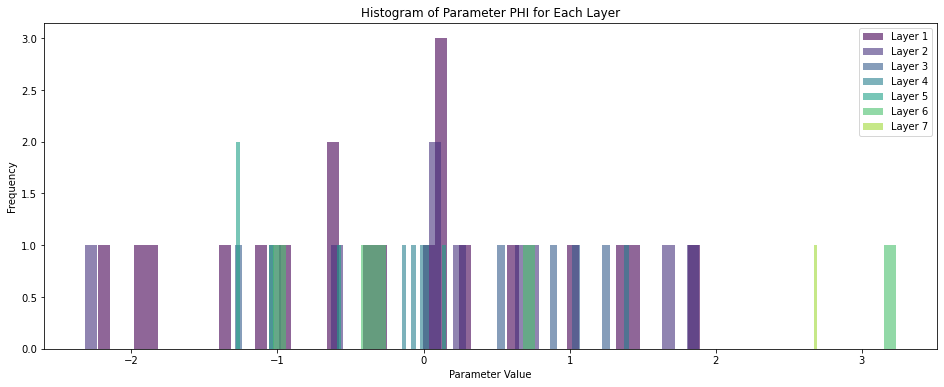

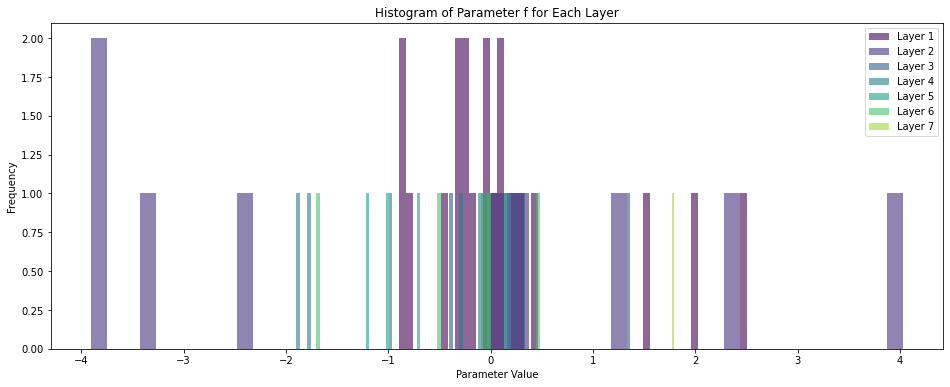

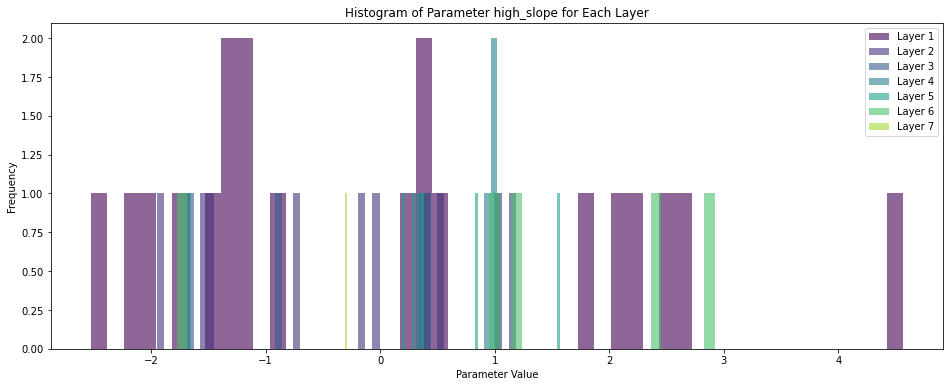

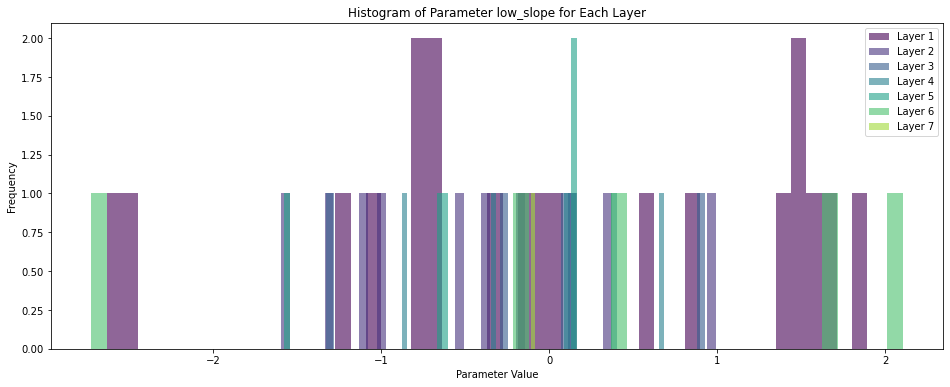

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your neural network and each layer has an 'a' parameter
layers = model.layers[:]  # List of layers in your model

# Create a new figure for the histogram
plt.figure(figsize=(16, 6))

# Loop through each layer and plot its parameter 'a' in a histogram
for idx, layer in enumerate(layers):
    if hasattr(layer, 'A'):  # Check if the layer has parameter 'a'
        data_x = layer.A.cpu().detach().numpy()  # Convert to numpy for plotting
        plt.hist(data_x, bins=50, alpha=0.6, color=plt.cm.viridis(idx / len(layers)), label=f'Layer {idx + 1}')

# Add titles and labels
plt.title('Histogram of Parameter a for Each Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(16, 6))
for idx, layer in enumerate(layers):
    if hasattr(layer, 'phi'):  # Check if the layer has parameter 'a'
        data_x = layer.phi.cpu().detach().numpy()  # Convert to numpy for plotting
        plt.hist(data_x, bins=50, alpha=0.6, color=plt.cm.viridis(idx / len(layers)), label=f'Layer {idx + 1}')

# Add titles and labels
plt.title('Histogram of Parameter PHI for Each Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(16, 6))
for idx, layer in enumerate(layers):
    if hasattr(layer, 'f'):  # Check if the layer has parameter 'a'
        data_x = layer.f.cpu().detach().numpy()  # Convert to numpy for plotting
        plt.hist(data_x, bins=50, alpha=0.6, color=plt.cm.viridis(idx / len(layers)), label=f'Layer {idx + 1}')

# Add titles and labels
plt.title('Histogram of Parameter f for Each Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(16, 6))
for idx, layer in enumerate(layers):
    if hasattr(layer, 'high_slope'):  # Check if the layer has parameter 'a'
        data_x = layer.high_slope.cpu().detach().numpy()  # Convert to numpy for plotting
        plt.hist(data_x, bins=50, alpha=0.6, color=plt.cm.viridis(idx / len(layers)), label=f'Layer {idx + 1}')

# Add titles and labels
plt.title('Histogram of Parameter high_slope for Each Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

plt.figure(figsize=(16, 6))
for idx, layer in enumerate(layers):
    if hasattr(layer, 'low_slope'):  # Check if the layer has parameter 'a'
        data_x = layer.low_slope.cpu().detach().numpy()  # Convert to numpy for plotting
        plt.hist(data_x, bins=50, alpha=0.6, color=plt.cm.viridis(idx / len(layers)), label=f'Layer {idx + 1}')

# Add titles and labels
plt.title('Histogram of Parameter low_slope for Each Layer')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [84]:
model.add

Parameter containing:
tensor([6.1798], requires_grad=True)